Collecting the data

In [2]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = 'AAPL'

# taking the start date as from year 2020 and end date till now
start_date = '2020-01-01'
end_date = '2024-04-26'  # Adjust the end date as needed

# Download the historical data using yahoo finance library
aapl_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Checking if data was downloaded successfully
if aapl_data.empty:
    print("No data found for the specified date range.")
else:
    # Save to CSV
    csv_filename = 'AAPL_2020_2024.csv'
    aapl_data.to_csv(csv_filename)
    print(f"Data successfully saved to {csv_filename}")

    # Optionally, display the first few rows
    print(aapl_data.head())


[*********************100%***********************]  1 of 1 completed

Data successfully saved to AAPL_2020_2024.csv
Price                      Adj Close      Close       High        Low  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2020-01-02 00:00:00+00:00  72.796028  75.087502  75.150002  73.797501   
2020-01-03 00:00:00+00:00  72.088280  74.357498  75.144997  74.125000   
2020-01-06 00:00:00+00:00  72.662712  74.949997  74.989998  73.187500   
2020-01-07 00:00:00+00:00  72.320984  74.597504  75.224998  74.370003   
2020-01-08 00:00:00+00:00  73.484344  75.797501  76.110001  74.290001   

Price                           Open     Volume  
Ticker                          AAPL       AAPL  
Date                                             
2020-01-02 00:00:00+00:00  74.059998  135480400  
2020-01-03 00:00:00+00:00  74.287498  146322800  
2020-01-06 00:00:00+00:00  73.447502  118387200  
2020-01-07 00:00:00+00:00  74.959999  108872000  
2020-01-08 00:00:00

In [3]:
df = aapl_data
df1 = df.reset_index()['Close']

In [4]:
df1.shape

(1086, 1)

In [5]:
df1

Ticker,AAPL
0,75.087502
1,74.357498
2,74.949997
3,74.597504
4,75.797501
...,...
1081,165.000000
1082,165.839996
1083,166.899994
1084,169.020004


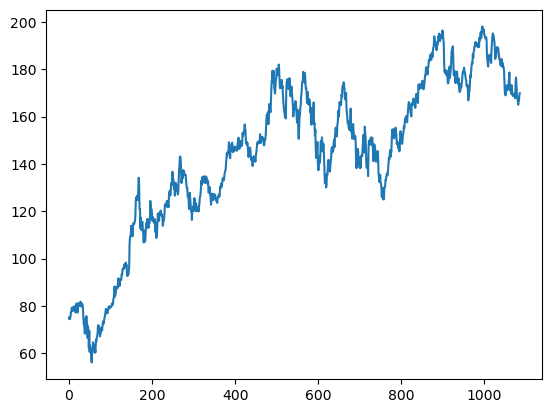

In [6]:
# plotting the close column
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
# Transforming values between (0,1) using MinMaxScaler since LSTM are sensitive
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
print(df1)

[[0.13375114]
 [0.1286109 ]
 [0.13278292]
 ...
 [0.78023831]
 [0.79516612]
 [0.80129209]]


Preprocessing the data

In [11]:
#splitting the data into training and testing data set
training_set_size = int(len(df1)*0.65)
testing_set_size = len(df1) - training_set_size
training_set_size, testing_set_size

(705, 381)

In [12]:
train_data, test_data = df1[0:training_set_size,:], df1[training_set_size:len(df1),:1]
len(train_data)

705

In [13]:
#Convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [15]:
#lets take time step as 100
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)
print(X_train.shape), print(Y_train.shape)

(604, 100)
(604,)


(None, None)

In [17]:
print(X_test.shape), print(Y_test.shape)
#output: (no. of records, no. of timesteps)

(280, 100)
(280,)


(None, None)

Create the stacked LSTM model

In [19]:
# reshape input to be [samples, time steps, features], since it is required in LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)

(604, 100, 1)


In [31]:
# creating stacked lstm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [32]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

C:\Users\Aditya Shinde\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 0.2461 - val_loss: 0.0212
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0181 - val_loss: 0.0426
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0054 - val_loss: 0.0171
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.0033 - val_loss: 0.0077
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s

Predict the test data and plot the output

In [34]:
#Lets do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [36]:
#Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [37]:
#Calculate Root Mean Square Error performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

137.69565043224108

In [38]:
math.sqrt(mean_squared_error(Y_test,test_predict))

173.84195045350356

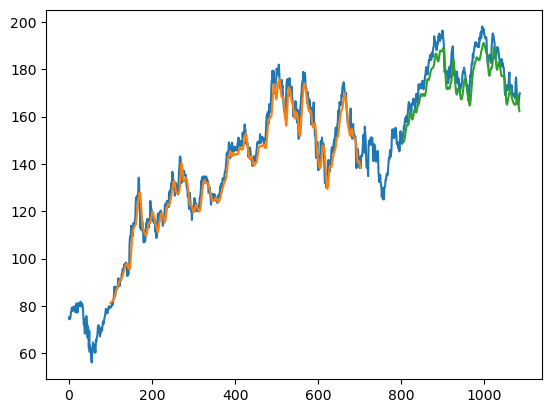

In [39]:
#Plotting 
#shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Predicting the future 30 days and plot the output

In [40]:
len(test_data)

381

In [42]:
#last 100 days data
x_input = test_data[281:].reshape(1,-1)
x_input.shape

(1, 100)

In [43]:
#converting it into a list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.9516257149392747,
 0.9388807166535281,
 0.9669758840921908,
 0.9592304243386801,
 0.9729611048752377,
 0.983100717407778,
 0.9652859128557613,
 0.9760593317538494,
 0.9989438351291181,
 0.9999999999999999,
 0.9961976990218065,
 0.9843681152528364,
 0.9917615916780654,
 0.9769042636505548,
 0.9758479913366546,
 0.9682433893802677,
 0.9643706057820031,
 0.9650746798815849,
 0.9681025315831439,
 0.9607090551579148,
 0.9121939123000661,
 0.9024063905388257,
 0.8859295738949565,
 0.8807892850086153,
 0.9116305885545896,
 0.9086732194731016,
 0.9160666958983305,
 0.9118418215287659,
 0.9141654916877245,
 0.8980407658151556,
 0.8913513634895086,
 0.9332476940847999,
 0.9538789024781625,
 0.9702853439449789,
 0.979368684163619,
 0.9745805934915962,
 0.9722569233326374,
 0.959934498438262,
 0.9550759251461681,
 0.9290931948922879,
 0.9034625554097077,
 0.9207844113933007,
 0.913672650562319,
 0.9265582917591527,
 0.9379654095797699,
 0.9387399662994228,
 0.9310648817229649,
 0.93479680752410

In [44]:
#demonstrate prediction for next 10 days
from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day out {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose = 0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1
        
print(lst_output)

[0.75034106]
101
1 day input [0.93888072 0.96697588 0.95923042 0.9729611  0.98310072 0.96528591
 0.97605933 0.99894384 1.         0.9961977  0.98436812 0.99176159
 0.97690426 0.97584799 0.96824339 0.96437061 0.96507468 0.96810253
 0.96070906 0.91219391 0.90240639 0.88592957 0.88078929 0.91163059
 0.90867322 0.9160667  0.91184182 0.91416549 0.89804077 0.89135136
 0.93324769 0.9538789  0.97028534 0.97936868 0.97458059 0.97225692
 0.9599345  0.95507593 0.92909319 0.90346256 0.92078441 0.91367265
 0.92655829 0.93796541 0.93873997 0.93106488 0.93479681 0.92282637
 0.90796904 0.90170221 0.89966025 0.88874609 0.88346505 0.88881657
 0.90325132 0.89022482 0.88064853 0.89099938 0.88247926 0.87776154
 0.87008646 0.83797775 0.80291158 0.79587019 0.79502526 0.80720683
 0.82143046 0.82481029 0.81002345 0.8231908  0.82051504 0.82826061
 0.84487828 0.86311545 0.81171331 0.818121   0.80805187 0.80002469
 0.82537361 0.81248787 0.80227788 0.79389861 0.79960212 0.79375786
 0.79910928 0.79115248 0.79974297

In [45]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [46]:
import matplotlib.pyplot as plt

In [47]:
len(df1)

1086

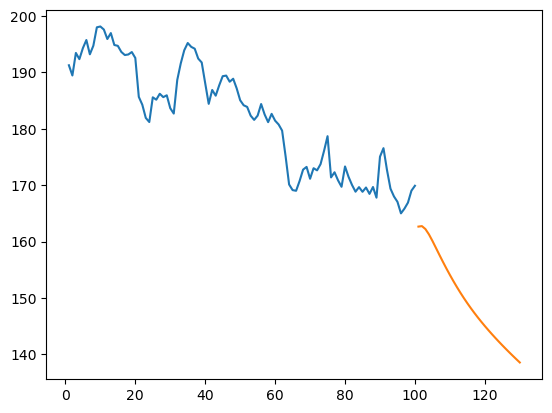

In [48]:
plt.plot(day_new, scaler.inverse_transform(df1[986:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

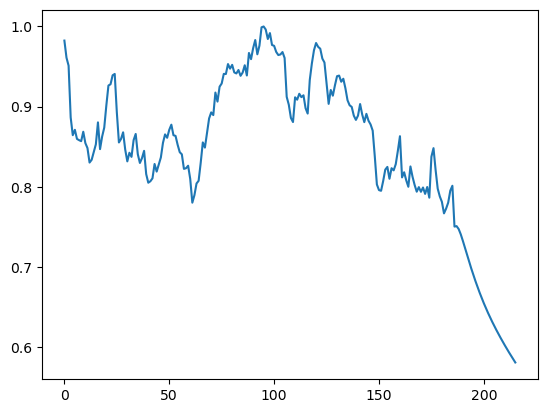

In [49]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[900:])